# TLC Workshop

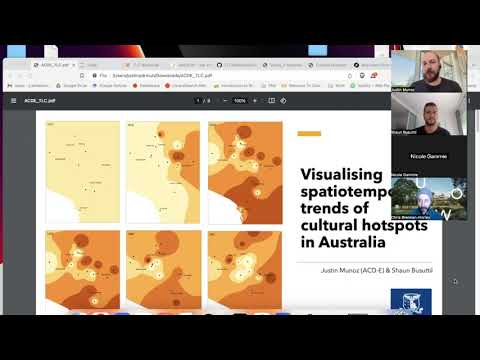

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo('J9MOMpYWpt8', width=800, height=400)

In [ ]:
### import modules
# for data/string manipulation
import re
import json
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter

# for plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# import plotly.express as px
# import sweetviz as sv
# px.set_mapbox_access_token("pk.eyJ1Ijoia2FiaXJtYW5hbmRoYXIiLCJhIjoiY2w3ZTMxYWxpMDNtajN3bHZvbHJyYThueiJ9.DpnmOuQdHCWU_crpaEZqAg")
# import plotly.graph_objects as go

import plotly.io as pio
import plotly.express as px
import plotly.offline as py

# # for network graphs
# import networkx as nx
# from pyvis import network as net

# optional
import warnings
warnings.filterwarnings('ignore')

#### Fetch data
#### Setlist fm data
# scraped data collected. Scraping occured on the 7/10/22
mel_df = pd.read_csv('data/melbourne_setlist_data.csv', index_col=0)

# remove redundant venues
mel_df = mel_df[mel_df.Venue != 'Unknown Venue, Melbourne, Australia']
mel_df = mel_df[mel_df.Venue != "Melbourne Hotel, Perth, Australia"]

# clean venue names
mel_df['Venue'] = mel_df['Venue'].str.replace(r', Melbourne, Australia', '')

# formalise date fields
dates = mel_df['Day'].astype(str)+"-"+mel_df['Month'].astype(str)+"-"+mel_df['Year'].astype(str)
mel_df['Date'] = dates.apply(lambda x: datetime.strptime(x,'%d-%b-%Y'))

# add decade column
mel_df['Decade'] = mel_df.Date.apply(lambda x: x.year // 10 * 10)

# drop any duplicate occurences
mel_df = mel_df.drop_duplicates(subset=['Date','Venue'], keep='first')

# show first rows
mel_df.head(5)

# venues_final.columns

# fix geocodes mistakes
venues_final = pd.read_csv('data/ACDE Internship-Final.csv', encoding='latin-1', index_col=0).iloc[:,1:]

new_lats = []
new_longs = []

for idx, ven in venues_final.iterrows():
    if ven.is_problem == 'No geocodes found.':
        new_lats.append(ven.Lat); new_longs.append(ven.Long)
        
    elif ven.is_problem == 'Same match for venue and address.':
        new_lats.append(ven.latitude2); new_longs.append(ven.longitude2)
        
    elif ven.is_problem == 'Address match, but venue no match. Check for accuracy.':
        new_lats.append(ven.latitude); new_longs.append(ven.longitude)
        
    elif ven.is_problem == 'Address match and venue match found but they conflict. Choose the most accurate.':
        new_lats.append(ven.latitude2); new_longs.append(ven.longitude2)
        
    else: pass
    
venues_final['new_lats'] = new_lats
venues_final['new_longs'] = new_longs
venues_final = venues_final[~venues_final.new_lats.isnull()]

venue_activity_complete = pd.read_csv('data/TLC_final_data.csv', index_col=0)
venue_activity_complete = pd.merge(venue_activity_complete, 
                                   venues_final[['Venue','Side of River','new_lats','new_longs']], 
                                   on=['Venue'])

venue_activity_complete.drop(['new_lats_x','new_longs_x'],axis=1, inplace=True)
venue_activity_complete = venue_activity_complete.rename(columns={'new_lats_y': 'new_lats', 'new_longs_y': 'new_longs'})

# DATA ENTRY error
venue_activity_complete.loc[venue_activity_complete.Venue.str.contains('Iceland'),'suburb_nopc'] = 'Ringwood VIC'

## Exploratory Data Analysis

### Temporal trends

In [ ]:
# create a frequency table of venue occurences by year
data_yearly = mel_df[['Year']]\
.value_counts()\
.reset_index()\
.groupby(['Year'])\
.sum()\
.reset_index()

# clean column names
data_yearly.columns = ['Year','Freq']

# visualise data over time
fig = px.line(data_yearly, 
              x="Year", 
              y="Freq",
              title= f'Venue activity in Melbourne, Yearly, 1869-2022')

fig.show()

In [ ]:
# create a frequency table of venue occurences by individual dates
data_daily = mel_df[['Date']]\
.value_counts()\
.reset_index()\
.groupby(['Date'])\
.sum()\
.reset_index()

# clean column names
data_daily.columns = ['Date','Freq']

# Get weekly count for last two years
daily_placeholder = pd.DataFrame({'Date': pd.date_range('2020-01-01', 
                                                        data_daily.iloc[-1]['Date'])})
data_daily = pd.merge(daily_placeholder, data_daily, on='Date', how='left')
data_daily = data_daily.set_index('Date')
data_daily = data_daily['Freq'].resample('D').sum() #.plot()
data_daily = pd.DataFrame(data_daily).reset_index()

# visualise data over time
fig = px.line(data_daily, 
              x="Date", 
              y="Freq",
              title= f'Venue activity in Melbourne, Daily, 2020-2022 <br><sup>Lockdowns highlighted in red</sup>')

highlighting_params = {'line_width': 0, 'fillcolor': 'red', 
                       'opacity': 0.1, 'annotation_position':"top right",
                       'annotation_textangle': 0}

fig.add_vrect(x0='2020-03-30', x1='2020-05-12', **highlighting_params, annotation_text="1st")
fig.add_vrect(x0='2020-08-08', x1='2020-10-27', **highlighting_params, annotation_text="2nd")
fig.add_vrect(x0='2021-02-12', x1='2021-02-17', **highlighting_params, annotation_text="3rd")
fig.add_vrect(x0='2021-05-27', x1='2021-06-10', **highlighting_params, annotation_text="4th")
fig.add_vrect(x0='2021-07-15', x1='2021-07-27', **highlighting_params, annotation_text="5th")
fig.add_vrect(x0='2021-08-05', x1='2021-10-21', **highlighting_params, annotation_text="6th")

fig.show()
# fig.write_image('COVID_MelbourneMusicScene.png' ,scale=5)

# from IPython.display import Image
# Image(filename='COVID_MelbourneMusicScene.png') 

In [ ]:
# create a frequency table of venue occurences by year
data_yearly = venue_activity_complete[['Year']]\
.value_counts()\
.reset_index()\
.groupby(['Year'])\
.sum()\
.reset_index()

# clean column names
data_yearly.columns = ['Year','Freq']

# visualise data over time
fig = px.line(data_yearly, 
              x="Year", 
              y="Freq",
              title= f'Venue activity in Melbourne, Yearly, 1974-2019')

fig.show()

### Venue Frequency

#### Suburb level

In [ ]:
venue_activity_complete['suburb_nopc'].value_counts().head(10).sort_values().plot(kind="barh"); plt.show()

In [ ]:
dfu = venue_activity_complete[venue_activity_complete.suburb_nopc\
                                .isin(venue_activity_complete['suburb_nopc'].\
                                      value_counts().head(10).index)]

dfu = dfu[dfu.suburb_nopc != 'Melbourne VIC']

# to get the dataframe in the correct shape, unstack the groupby result
dfu = dfu.groupby(['Decade']).suburb_nopc.value_counts(normalize=True).unstack()

# plot
ax = dfu.plot(kind='line', figsize=(7, 5), xlabel='Decade', ylabel='Prop', rot=0, marker='.')
ax.legend(title='', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [ ]:
dfu = venue_activity_complete[venue_activity_complete.suburb_nopc\
                                .isin(venue_activity_complete['suburb_nopc'].\
                                      value_counts().head(6).index)]

dfu = dfu[dfu.suburb_nopc != 'Melbourne VIC']

# to get the dataframe in the correct shape, unstack the groupby result
dfu = dfu.groupby(['Decade']).suburb_nopc.value_counts().unstack()

# plot
ax = dfu.plot(kind='bar', figsize=(7, 5), xlabel='Decade', ylabel='Freq', rot=0)
ax.legend(title='', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

#### North or South of the river?

In [ ]:
venue_activity_complete['Side of River'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
plt.show()

In [ ]:
# to get the dataframe in the correct shape, unstack the groupby result
dfu = venue_activity_complete.groupby(['Decade'])['Side of River'].value_counts(normalize=True).unstack()

# plot
ax = dfu.plot(kind='line', figsize=(7, 5), xlabel='Decade', ylabel='Prop', rot=0, marker='.')
ax.legend(title='North or South River?', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [ ]:
dfu = venue_activity_complete.groupby(['Decade'])['Side of River'].value_counts().unstack()

# plot
ax = dfu.plot(kind='bar', figsize=(7, 5), xlabel='Decade', ylabel='Freq', rot=0)
ax.legend(title='North or South River?', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Top venues by decade

In [ ]:
# create a frequency table of venue occurences by decade 
all_events = venue_activity_complete[['Venue','Decade']]\
.value_counts().reset_index()\
.groupby(['Venue','Decade'])\
.sum()\
.reset_index()

# clean column names
all_events.columns = ['Venue','Decade','Freq']

# show first rows
all_events.sort_values('Freq',ascending=False).head(10)

#### 1970s

In [ ]:
top_venues = all_events[(all_events.Freq >= 1)]['Venue'].unique()
active_in_1970s = all_events[(all_events.Decade == 1970) & (all_events.Freq > 40)]['Venue'].unique()
top_venues_70s = list(set(top_venues) & set(active_in_1970s))

top_in_state = all_events[all_events.Venue.isin(top_venues_70s)]\
.sort_values(['Decade','Venue'])

fig = px.line(top_in_state.sort_values('Decade'), 
              x="Decade", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Music venues active in 1970s (Melbourne):</b> Decades',
              markers=True)

fig.show()

In [ ]:
all_events_yr = venue_activity_complete[venue_activity_complete.Venue.isin(active_in_1970s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 1965) & (all_events_yr.Year < 1980)]

fig = px.line(all_events_yr.sort_values('Year'), 
              x="Year", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Music venues most active in 1970s (Melbourne):</b> Year',markers=True)
fig.show()

In [ ]:
active_in_1970s = all_events[(all_events.Decade == 1970)]['Venue'].unique()
all_events_yr = venue_activity_complete[venue_activity_complete.Venue.isin(active_in_1970s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 1973) & (all_events_yr.Year < 1980) &
                              (all_events_yr.Venue.isin(all_events_yr[all_events_yr.Freq > 5]['Venue'].unique()))]

piv70s = all_events_yr.pivot(index='Venue', columns='Year', values='Freq').fillna(0)
clipped = piv70s.clip(upper=1).sum(axis=1).reset_index()
piv70s = piv70s[piv70s.index.isin(clipped[clipped[0] > 1].Venue)]

change70s = piv70s.copy()
# change70s['70-71'] = change70s[[1970,1971]].pct_change(axis=1)[1971]
# change70s['71-72'] = change70s[[1971,1972]].pct_change(axis=1)[1972]
# change70s['72-73'] = change70s[[1972,1973]].pct_change(axis=1)[1973]
# change70s['73-74'] = change70s[[1973,1974]].pct_change(axis=1)[1974]
change70s['74-75'] = change70s[[1974,1975]].pct_change(axis=1)[1975]
change70s['75-76'] = change70s[[1975,1976]].pct_change(axis=1)[1976]
change70s['76-77'] = change70s[[1976,1977]].pct_change(axis=1)[1977]
change70s['77-78'] = change70s[[1977,1978]].pct_change(axis=1)[1978]
change70s['78-79'] = change70s[[1978,1979]].pct_change(axis=1)[1979]
change70s = change70s.drop([1974,1975,1976,1977,1978,1979],axis=1).unstack().reset_index()
# change70s = change70s.drop([1970,1971,1972,1973,1974,1975,1976,1977,1978,1979],axis=1).unstack().reset_index()
change70s = change70s[~change70s.isin([np.nan, np.inf, -np.inf]).any(1)]
biggestmovers70s = change70s.sort_values(0, ascending=False).head(5)['Venue'].unique()

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(piv70s, annot=True)
ax.set(xlabel="", ylabel="")
plt.show()

In [ ]:
forheatmap = change70s[change70s['Venue'].isin(biggestmovers70s)].pivot(index='Venue', columns='Year', values=0).fillna(0)
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(forheatmap, annot=True)
ax.set(xlabel="", ylabel="")
plt.title('Largest YoY fluctuations fot venues in the 70s')
plt.show()

In [ ]:
all_events_yr = venue_activity_complete[venue_activity_complete.Venue.isin(biggestmovers70s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 1970) & (all_events_yr.Year < 1985)]

fig = px.line(all_events_yr.sort_values('Year'), 
              x="Year", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Venues, Biggest Movers, 1970s (Melbourne):</b> Year',markers=True)
fig.show()

Which band played at the Bananas the most times?

In [ ]:
# Which band played at the Bananas the most times?
venue_activity_complete[venue_activity_complete['Venue'].str.contains('Bananas')].Artist.value_counts().head(3)

Which band played at the Hearts Nightclub (Polaris Inn) the most times?

In [ ]:
# Which band played at the Hearts Nightclub (Polaris Inn) the most times?
venue_activity_complete[venue_activity_complete['Venue'].str.contains('Polaris Inn')].Artist.value_counts().head(3)

Which venue did The Boys Next Door / The Birthday Party play most at? 

In [ ]:
# Which venue did The Boys Next Door / The Birthday Party play most at? 
venue_activity_complete[(venue_activity_complete['Artist'].str.contains('The Boys Next Door')) |
             (venue_activity_complete['Artist'].str.contains('The Birthday Party'))].Venue.value_counts().head(5)

#### 1980s

In [ ]:
top_venues = all_events[(all_events.Freq >= 1)]['Venue'].unique()
active_in_1980s = all_events[(all_events.Decade == 1980) & (all_events.Freq > 50)]['Venue'].unique()
top_venues_80s = list(set(top_venues) & set(active_in_1980s))

top_in_state = all_events[all_events.Venue.isin(top_venues_80s)].sort_values(['Decade','Venue'])
top_in_state = top_in_state[top_in_state.Decade > 1969]

fig = px.line(top_in_state.sort_values('Decade'), 
              x="Decade", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Music venues active in 1980s (Melbourne):</b> Music',markers=True)

fig.show()

In [ ]:
all_setlists = venue_activity_complete
all_events_yr = all_setlists[all_setlists.Venue.isin(active_in_1980s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 1975) & (all_events_yr.Year < 1990)]

fig = px.line(all_events_yr.sort_values('Year'), 
              x="Year", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Music venues active in 1980s (Melbourne):</b> Year',markers=True)
fig.show()

In [ ]:
active_in_1980s = all_events[(all_events.Decade == 1980)]['Venue'].unique()
all_events_yr = all_setlists[all_setlists.Venue.isin(active_in_1980s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 1979) & (all_events_yr.Year < 1990) &
                              (all_events_yr.Venue.isin(all_events_yr[all_events_yr.Freq > 5]['Venue'].unique()))]

piv80s = all_events_yr.pivot(index='Venue', columns='Year', values='Freq').fillna(0)
clipped = piv80s.clip(upper=1).sum(axis=1).reset_index()
piv80s = piv80s[piv80s.index.isin(clipped[clipped[0] > 1].Venue)]

change80s = piv80s.copy()
change80s['80-81'] = change80s[[1980,1981]].pct_change(axis=1)[1981]
change80s['81-82'] = change80s[[1981,1982]].pct_change(axis=1)[1982]
change80s['82-83'] = change80s[[1982,1983]].pct_change(axis=1)[1983]
change80s['83-84'] = change80s[[1983,1984]].pct_change(axis=1)[1984]
change80s['84-85'] = change80s[[1984,1985]].pct_change(axis=1)[1985]
change80s['85-86'] = change80s[[1985,1986]].pct_change(axis=1)[1986]
change80s['86-87'] = change80s[[1986,1987]].pct_change(axis=1)[1987]
change80s['87-88'] = change80s[[1987,1988]].pct_change(axis=1)[1988]
change80s['88-89'] = change80s[[1988,1989]].pct_change(axis=1)[1989]
change80s = change80s.drop([1980,1981,1982,1983,1984,1985,1986,1987,1988,1989],axis=1).unstack().reset_index() 
change80s = change80s[~change80s.isin([np.nan, np.inf, -np.inf]).any(1)]
biggestmovers80s = change80s.sort_values(0, ascending=False).head(5)['Venue'].unique()

In [ ]:
print('Largest YoY fluctuations for venues in the 80s')
change80s.sort_values(0, ascending=False).head(5)

In [ ]:
# change80s.sort_values(0, ascending=False).head(10).value_counts('Year')

In [ ]:
all_events_yr = all_setlists[all_setlists.Venue.isin(biggestmovers80s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 1980) & (all_events_yr.Year < 1995)]

fig = px.line(all_events_yr.sort_values('Year'), 
              x="Year", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Venues, Biggest Movers, 1980s (Melbourne):</b> Year',markers=True)
fig.show()

#### 1990s

In [ ]:
top_venues = all_events[(all_events.Freq >= 1)]['Venue'].unique()
active_in_1990s = all_events[(all_events.Decade == 1990) & (all_events.Freq > 100)]['Venue'].unique()
top_venues_90s = list(set(top_venues) & set(active_in_1990s))

top_in_state = all_events[all_events.Venue.isin(top_venues_90s)].sort_values(['Decade','Venue'])
top_in_state = top_in_state[top_in_state.Decade > 1979]

fig = px.line(top_in_state.sort_values('Decade'), 
              x="Decade", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Music venues active in 1990s (Melbourne):</b> Decades',markers=True)

fig.show()

In [ ]:
all_events_yr = all_setlists[all_setlists.Venue.isin(active_in_1990s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 1985) & (all_events_yr.Year < 2000)]

fig = px.line(all_events_yr.sort_values('Year'), 
              x="Year", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Music venues active in 1990s (Melbourne):</b> Year',markers=True)
fig.show()

In [ ]:
active_in_1990s = all_events[(all_events.Decade == 1990)]['Venue'].unique()
all_events_yr = all_setlists[all_setlists.Venue.isin(active_in_1990s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 1989) & (all_events_yr.Year < 2000) &
                              (all_events_yr.Venue.isin(all_events_yr[all_events_yr.Freq > 5]['Venue'].unique()))]

piv90s = all_events_yr.pivot(index='Venue', columns='Year', values='Freq').fillna(0)
clipped = piv90s.clip(upper=1).sum(axis=1).reset_index()
piv90s = piv90s[piv90s.index.isin(clipped[clipped[0] > 1].Venue)]

change90s = piv90s.copy()
change90s['90-91'] = change90s[[1990,1991]].pct_change(axis=1)[1991]
change90s['91-92'] = change90s[[1991,1992]].pct_change(axis=1)[1992]
change90s['92-93'] = change90s[[1992,1993]].pct_change(axis=1)[1993]
change90s['93-94'] = change90s[[1993,1994]].pct_change(axis=1)[1994]
change90s['94-95'] = change90s[[1994,1995]].pct_change(axis=1)[1995]
change90s['95-96'] = change90s[[1995,1996]].pct_change(axis=1)[1996]
change90s['96-97'] = change90s[[1996,1997]].pct_change(axis=1)[1997]
change90s['97-98'] = change90s[[1997,1998]].pct_change(axis=1)[1998]
change90s['98-99'] = change90s[[1998,1999]].pct_change(axis=1)[1999]
change90s = change90s.drop([1990,1991,1992,1993,1994,1995,1996,1997,1998,1999],axis=1).unstack().reset_index() 
change90s = change90s[~change90s.isin([np.nan, np.inf, -np.inf]).any(1)]
biggestmovers90s = change90s.sort_values(0, ascending=False).head(5)['Venue'].unique()

In [ ]:
print('Largest YoY fluctuations fot venues in the 90s')
change90s.sort_values(0, ascending=False).head(5)

In [ ]:
# change90s.sort_values(0, ascending=False).head(10).value_counts('Year')

In [ ]:
all_events_yr = all_setlists[all_setlists.Venue.isin(biggestmovers90s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 1990) & (all_events_yr.Year < 2000)]

fig = px.line(all_events_yr.sort_values('Year'), 
              x="Year", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Venues, Biggest Movers, 1990s (Melbourne):</b> Year',markers=True)
fig.show()

#### 2000s

In [ ]:
top_venues = all_events[(all_events.Freq >= 1)]['Venue'].unique()
active_in_2000s = all_events[(all_events.Decade == 2000) & (all_events.Freq > 150)]['Venue'].unique()
top_venues_00s = list(set(top_venues) & set(active_in_2000s))

top_in_state = all_events[all_events.Venue.isin(top_venues_00s)].sort_values(['Decade','Venue'])
top_in_state = top_in_state[top_in_state.Decade > 1989]

fig = px.line(top_in_state.sort_values('Decade'), 
              x="Decade", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Top music venues active in 2000s (Melbourne):</b> Decades',markers=True)

fig.show()

In [ ]:
all_events_yr = all_setlists[all_setlists.Venue.isin(active_in_2000s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 1995) & (all_events_yr.Year < 2010)]

fig = px.line(all_events_yr.sort_values('Year'), 
              x="Year", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Music venues active in 2000s (Melbourne):</b> Year',markers=True)
fig.show()

In [ ]:
active_in_2000s = all_events[(all_events.Decade == 2000)]['Venue'].unique()
all_events_yr = all_setlists[all_setlists.Venue.isin(active_in_2000s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 1999) & (all_events_yr.Year < 2010) &
                              (all_events_yr.Venue.isin(all_events_yr[all_events_yr.Freq > 5]['Venue'].unique()))]

piv00s = all_events_yr.pivot(index='Venue', columns='Year', values='Freq').fillna(0)
clipped = piv00s.clip(upper=1).sum(axis=1).reset_index()
piv00s = piv00s[piv00s.index.isin(clipped[clipped[0] > 1].Venue)]

change00s = piv00s.copy()
change00s['00-01'] = change00s[[2000,2001]].pct_change(axis=1)[2001]
change00s['01-02'] = change00s[[2001,2002]].pct_change(axis=1)[2002]
change00s['02-03'] = change00s[[2002,2003]].pct_change(axis=1)[2003]
change00s['03-04'] = change00s[[2003,2004]].pct_change(axis=1)[2004]
change00s['04-05'] = change00s[[2004,2005]].pct_change(axis=1)[2005]
change00s['05-06'] = change00s[[2005,2006]].pct_change(axis=1)[2006]
change00s['06-07'] = change00s[[2006,2007]].pct_change(axis=1)[2007]
change00s['07-08'] = change00s[[2007,2008]].pct_change(axis=1)[2008]
change00s['08-09'] = change00s[[2008,2009]].pct_change(axis=1)[2009]
change00s = change00s.drop([2000,2001,2002,2003,2004,2005,2006,2007,2008,2009],axis=1).unstack().reset_index() 
change00s = change00s[~change00s.isin([np.nan, np.inf, -np.inf]).any(1)]
biggestmovers00s = change00s.sort_values(0, ascending=False).head(5)['Venue'].unique()

In [ ]:
print('Largest YoY fluctuations for venues in the 00s')
change00s.sort_values(0, ascending=False).head(5)

In [ ]:
# change00s.sort_values(0, ascending=False).head(10).value_counts('Year')

In [ ]:
all_events_yr = all_setlists[all_setlists.Venue.isin(biggestmovers00s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 1995) & (all_events_yr.Year < 2010)]

fig = px.line(all_events_yr.sort_values('Year'), 
              x="Year", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Venues, Biggest Movers, 2000s (Melbourne):</b> Year',markers=True)
fig.show()

#### 2010s

In [ ]:
top_venues = all_events[(all_events.Freq >= 1)]['Venue'].unique()
active_in_2010s = all_events[(all_events.Decade == 2010) & (all_events.Freq > 250)]['Venue'].unique()
top_venues_10s = list(set(top_venues) & set(active_in_2010s))

top_in_state = all_events[all_events.Venue.isin(top_venues_00s)].sort_values(['Decade','Venue'])
top_in_state = top_in_state[top_in_state.Decade > 1999]

fig = px.line(top_in_state.sort_values('Decade'), 
              x="Decade", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Top music venues active in 2010s (Melbourne):</b> Decades',markers=True)

fig.show()

In [ ]:
all_events_yr = all_setlists[all_setlists.Venue.isin(active_in_2000s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 2005) & (all_events_yr.Year < 2015)]

fig = px.line(all_events_yr.sort_values('Year'), 
              x="Year", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Music venues active in 2010s (Melbourne):</b> Year',markers=True)
fig.show()

In [ ]:
active_in_2010s = all_events[(all_events.Decade == 2010)]['Venue'].unique()
all_events_yr = all_setlists[all_setlists.Venue.isin(active_in_2010s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 2009) & (all_events_yr.Year < 2020) &
                              (all_events_yr.Venue.isin(all_events_yr[all_events_yr.Freq > 5]['Venue'].unique()))]

piv10s = all_events_yr.pivot(index='Venue', columns='Year', values='Freq').fillna(0)
clipped = piv10s.clip(upper=1).sum(axis=1).reset_index()
piv10s = piv10s[piv10s.index.isin(clipped[clipped[0] > 1].Venue)]

change10s = piv10s.copy()
change10s['10-11'] = change10s[[2010,2011]].pct_change(axis=1)[2011]
change10s['11-12'] = change10s[[2011,2012]].pct_change(axis=1)[2012]
change10s['12-13'] = change10s[[2012,2013]].pct_change(axis=1)[2013]
change10s['13-14'] = change10s[[2013,2014]].pct_change(axis=1)[2014]
change10s['14-15'] = change10s[[2014,2015]].pct_change(axis=1)[2015]
change10s['15-16'] = change10s[[2015,2016]].pct_change(axis=1)[2016]
change10s['16-17'] = change10s[[2016,2017]].pct_change(axis=1)[2017]
change10s['17-18'] = change10s[[2017,2018]].pct_change(axis=1)[2018]
change10s['18-19'] = change10s[[2018,2019]].pct_change(axis=1)[2019]
change10s = change10s.drop([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019],axis=1).unstack().reset_index() 
change10s = change10s[~change10s.isin([np.nan, np.inf, -np.inf]).any(1)]
biggestmovers10s = change10s.sort_values(0, ascending=False).head(5)['Venue'].unique()

In [ ]:
print('Largest YoY fluctuations for venues in the 2010s')
change10s.sort_values(0, ascending=False).head(5)

In [ ]:
# change10s.sort_values(0, ascending=False).head(10).value_counts('Year')

In [ ]:
all_events_yr = all_setlists[all_setlists.Venue.isin(biggestmovers10s)][['Venue','Year']]\
.value_counts().reset_index().groupby(['Venue','Year']).sum().reset_index()
all_events_yr.columns = ['Venue','Year','Freq']
all_events_yr.Year = all_events_yr.Year.astype(int)
all_events_yr = all_events_yr[(all_events_yr.Year > 2005) & (all_events_yr.Year < 2015)]

fig = px.line(all_events_yr.sort_values('Year'), 
              x="Year", y="Freq", color="Venue",line_group="Venue",
              title= f'<b>Venues, Biggest Movers, 2010s (Melbourne):</b> Year',markers=True)
fig.show()

### Genre

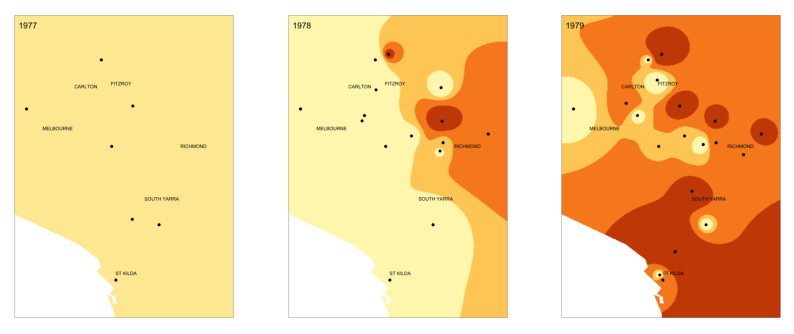

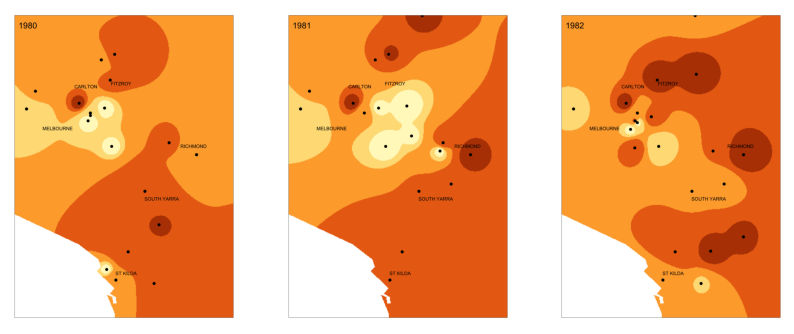

In [18]:
# from IPython.display import Image
# Image(filename='images/1977.png') 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 10,7

# read images
img_A = mpimg.imread('images/1977.png')
img_B = mpimg.imread('images/1978.png')
img_C = mpimg.imread('images/1979.png')
img_D = mpimg.imread('images/1980.png')
img_E = mpimg.imread('images/1981.png')
img_F = mpimg.imread('images/1982.png')

# display images
fig, ax = plt.subplots(1,3)
ax[0].imshow(img_A)
ax[1].imshow(img_B)
ax[2].imshow(img_C)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

fig, ax = plt.subplots(1,3)
ax[0].imshow(img_D)
ax[1].imshow(img_E)
ax[2].imshow(img_F)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

## Genre Map and Network analysis

 Explore cultural hotspots over time using this [tool](https://jmunoz.shinyapps.io/CulturalHotspotsTLC/).